In [1]:
hidden_layers = (75,50)
img_dimensions = (300,300)
data_type = "unsynth"
rotating = True
flipping = True
add_noise = False
change_hue = False
brightness = False
#classifier = "MLP"
classifier = "CNN"
data = []
test_set_images = []
test_set_labels = []
use_validation = True

Loading data + Preprocessing 

In [2]:
import skimage as ski
import numpy as np
import os
from skimage.transform import rescale, resize, downscale_local_mean

if data_type == "unsynth" and data == []:
    data = []
    labels = []
    images = []
    label = 0

    for folder in os.listdir("Datasets/unsynth"):
        # nb = 0
        for file in os.listdir("Datasets/unsynth/" + folder):
            # nb += 1
            # if nb >= 10:
            #     break
            img = ski.io.imread("Datasets/unsynth/" + folder + "/" + file)
            imgResized = resize(img, img_dimensions)
            images.append(imgResized)
            #prep = imgResized.astype(float)
            #prep = imgResized.astype(np.uint8)
            labels.append(label)
        label+=1


In [3]:
import skimage as ski
import numpy as np
import os
from skimage.transform import rescale, resize, downscale_local_mean

if data_type == "synth" and data == []:
    data = []
    labels = []
    images = []
    label = 0

    for folder in os.listdir("Datasets/synth"):
        nb = 0
        for file in os.listdir("Datasets/synth/" + folder):
            if nb >= 200:
                break
            nb += 1
            img = ski.io.imread("Datasets/synth/" + folder + "/" + file)
            imgResized = resize(img, img_dimensions)
            images.append(imgResized)
            #prep = imgResized.astype(float)
            #prep = imgResized.astype(np.uint8)
            labels.append(label)
        label+=1

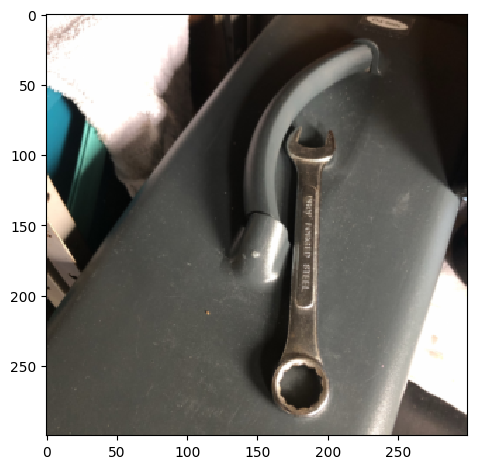

In [4]:
from matplotlib import pyplot as plt
from skimage import io
down_scaled_image = resize(images[0], (300, 300))
io.imshow(down_scaled_image)
plt.show()


Rotating

In [5]:
from skimage import io
from skimage.transform import rotate
from matplotlib import pyplot as plt
from numpy import flipud

if rotating:
    newImages = []
    newLabels = []
    rotations = [0, 90, 180, 270]
    for i in range(len(images)):
        originalImage = images[i]
        for rotation in rotations:
            rotatedImage = rotate(originalImage, rotation)
            newImages.append(rotatedImage)
            newLabels.append(labels[i])
        #newImages.append(np.ndarray.flatten(flipud(rotatedImage)))
        #newLabels.append(labels[i])

    images.extend(newImages)
    labels.extend(newLabels)

In [6]:
if flipping:
    newImages = []
    newLabels = []
    for i in range(len(images)):
        originalImage = images[i]
        newImages.append(flipud(originalImage))
        newLabels.append(labels[i])

    images.extend(newImages)
    labels.extend(newLabels)

Brightness

In [7]:
from skimage import exposure
if brightness:
    newImages = []
    newLabels = []
    gammas = [0.75, 0.875, 1, 1.125, 1.25]
    for i in range(len(images)):
        originalImage = images[i]
        for gamma in gammas:
            brightness_changed_image = exposure.adjust_gamma(originalImage, gamma)
            newImages.append(brightness_changed_image)
            newLabels.append(labels[i])
            #newImages.append(np.ndarray.flatten(flipud(rotatedImage)))
            #newLabels.append(labels[i])

    images.extend(newImages)
    labels.extend(newLabels)

Noise

In [8]:
if add_noise:
    noise = np.random.normal(0, 0.1, (len(images), len(images[0]), len(images[0][0]), len(images[0][0][0])))
    noised_images = images + noise
    #noised_data = []
    #for img in noised_images:
    #    img = np.ndarray.flatten(img)
    #    noised_data.append(img)

    labels.extend(labels)
    images.extend(noised_images)

First we make a classifier based on the not augmented data:

In [9]:
len(images)

2030

In [10]:
if classifier == "MLP":
    for img in images:
        data.append(np.ndarray.flatten(img))

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
if classifier == "MLP":
    trainData, testData, trainLabel, testLabel = train_test_split(data, labels, test_size=0.2, random_state=2056621)

    clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(100, 100, 100), random_state=2056621, max_iter=300, verbose=True)
    clf.fit(trainData, trainLabel)

    predLabel = clf.predict(testData)

    

In [12]:
if classifier == "MLP":
    classification_report(testLabel, predLabel)

In [13]:
print(len(data))

0


In [14]:
from joblib import dump

if classifier == "MLP":
    dump(clf, 'a.model')

Verslag
-beginnen met trainen normale dataset om gewoon te proberen(na alle images naar 1000, 1000 te doen)
-slechte resultaten zoals verwacht (slechter dan random guesses)
-dan roteren + flippen toegepast -> aantal images maal 8
-paste niet meer in RAM -> disk schrijven wat het heel traag maakte
-alleen roteren past het wel in RAM + kleinere images (1000, 1000) -> (500, 500)
-hidden layer size ook naar (100, 100, 100, 100)
-dit gaf redelijke resultaten, max iterations stond nog op 50 wel + warning niet convergeren
-na dit weg te laten convergeerde het met wat betere resultaten
-200 200 200 200 gaf niet meteen betere resultaten dan 100 100 100 100, accuracy was zelfs omlaag
-nu proberen we om aantal dingen te veranderen (changing brightness, hue, noise, and randomly combining all previous methods)

-brightness gaf goede resultaten, maar wss overfitten (5x bijna dezelfde images)
-normaliseren images doen we nu (delen door 255, helpt overfitten tegen te gaan en sneller convergeren)
-Gustavo had gezegd: training op gegenereerde en testen op echte images
-noise geeft goede resultaten (we gebruiken maar 100 100)
-size images naar (300, 300), zagen er nog altijd herkenbaar uit
-trainen op synthetic data als trainset en normale data als testset geeft slechte resultaten (1/4 accuracy = gokken)
-ook eerst problemen met RGB(a) wat niet hetzelfde formaat was tussen synthetic & unsynth

-CNN geprobeerd: werkt beter + sneller dan MLPclassifier
-rotaten + flippen geeft 0.70 accuracy, brightness geeft 0.99 (heel hard overfitten), noise geeft 0.33 en synth geeft 1/4
-dropout toegevoegd om overfitten tegen te gaan
-rotaten + flippen geeft nu nog maar 0.5, maar heb wel het gevoel dat met meer epochs beter kan
-validation toegevoegd: accuracy ervan zit lager dan de train accuracy (niet zo heel onverwacht), gelijkaardig aan test accuracy 


Volgende stappen:
-Trainen op synthetic images
-


In [15]:
if data_type == "synth" and test_set_images != []:
    test_set_images = []
    test_set_labels = []
    label = 0
    for folder in os.listdir("Datasets/unsynth"):
        # nb = 0
        for file in os.listdir("Datasets/unsynth/" + folder):
            # nb += 1
            # if nb >= 10:
            #     break
            img = ski.io.imread("Datasets/unsynth/" + folder + "/" + file)
            imgResized = resize(img, (300,300))
            test_set_images.append(imgResized)
            #prep = imgResized.astype(float)
            #prep = imgResized.astype(np.uint8)
            test_set_labels.append(label)
        label+=1

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

if data_type == "synth":
    def RGBA_to_RGB(images):
        return np.delete(arr=images, axis=3, obj=3)

    images = RGBA_to_RGB(images)
    trainData = []
    for image in images:
        trainData.append(np.ndarray.flatten(image) / 255)
    trainLabel = labels
    testData = []

    for image in test_set_images:
        testData.append(np.ndarray.flatten(image) / 255)
    testLabel = test_set_labels
    if classifier == "MLP":
        clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(100, 100, 100), random_state=2056621, max_iter=300, verbose=True)
        clf.fit(trainData, trainLabel)

        predLabel = clf.predict(testData)

        classification_report(testLabel, predLabel)

In [18]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras import datasets, layers, models

if classifier == "CNN":

    model = models.Sequential()
    model.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape=(300, 300, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(150, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(100, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(hidden_layers[0], activation='relu'))
    for i in range(1, len(hidden_layers)):
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(hidden_layers[i]))
    model.add(layers.Dense(4))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    trainData, testData, trainLabel, testLabel = train_test_split(images, labels, test_size=0.2, random_state=2056621)
    trainData = np.asarray(trainData) / 255
    testData = np.asarray(testData) / 255
    if use_validation:
        history = model.fit(np.asarray(trainData), np.asarray(trainLabel), epochs=7, validation_split=0.1)
    else:
        history = model.fit(np.asarray(trainData), np.asarray(trainLabel), epochs=10)

    test_loss, test_acc = model.evaluate(np.asarray(testData), np.asarray(testLabel), verbose=2)
    print("Accuracy:" + str(test_acc))



Epoch 1/7


46/46 [==============================] - 559s 12s/step - loss: 1.3878 - accuracy: 0.2355 - val_loss: 1.3862 - val_accuracy: 0.2577
Epoch 2/7
46/46 [==============================] - 475s 10s/step - loss: 1.3867 - accuracy: 0.2560 - val_loss: 1.3865 - val_accuracy: 0.2577
Epoch 3/7
46/46 [==============================] - 416s 9s/step - loss: 1.3870 - accuracy: 0.2375 - val_loss: 1.3850 - val_accuracy: 0.2577
Epoch 4/7
46/46 [==============================] - 403s 9s/step - loss: 1.3871 - accuracy: 0.2423 - val_loss: 1.3863 - val_accuracy: 0.2147
Epoch 5/7
46/46 [==============================] - 535s 12s/step - loss: 1.3866 - accuracy: 0.2553 - val_loss: 1.3848 - val_accuracy: 0.2577
Epoch 6/7
46/46 [==============================] - 694s 15s/step - loss: 1.3870 - accuracy: 0.2553 - val_loss: 1.3846 - val_accuracy: 0.2577
Epoch 7/7
46/46 [==============================] - 693s 15s/step - loss: 1.3867 - accuracy: 0.2444 - val_loss: 1.3856 - val_accuracy: 0.2577
13/13 - 57s -

In [ ]:
print(len(images))

2030


In [ ]:
inputString = "              precision    recall  f1-score   support\n\n           0       0.98      1.00      0.99        52\n           1       1.00      1.00      1.00        51\n           2       1.00      0.98      0.99        50\n           3       1.00      1.00      1.00        50\n\n    accuracy                           1.00       203\n   macro avg       1.00      0.99      1.00       203\nweighted avg       1.00      1.00      1.00       203\n"
parsed_string = inputString.split('\n')
for line in parsed_string:
    print(line)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      1.00      1.00        51
           2       1.00      0.98      0.99        50
           3       1.00      1.00      1.00        50

    accuracy                           1.00       203
   macro avg       1.00      0.99      1.00       203
weighted avg       1.00      1.00      1.00       203



In [ ]:
import skimage as ski
from skimage.transform import rescale, resize, downscale_local_mean
import os
root_folder = "testimages/"
testlabels = []
testimages = []
testlabel = 0

for folder in os.listdir(root_folder):
    # nb = 0
    for file in os.listdir(root_folder + folder):
        # nb += 1
        # if nb >= 10:
        #     break
        img = ski.io.imread(root_folder + folder + "/" + file)
        imgResized = resize(img, img_dimensions)
        testimages.append(imgResized)
        #prep = imgResized.astype(float)
        #prep = imgResized.astype(np.uint8)
        testlabels.append(testlabel)
    testlabel+=1

In [ ]:
import skimage as ski
from skimage.transform import rescale, resize, downscale_local_mean
import os
root_folder = "datasets/unsynth/"
testlabels = []
testimages = []
testlabel = 0

for folder in os.listdir(root_folder):
    # nb = 0
    for file in os.listdir(root_folder + folder):
        # nb += 1
        # if nb >= 10:
        #     break
        img = ski.io.imread(root_folder + folder + "/" + file)
        imgResized = resize(img, img_dimensions)
        testimages.append(imgResized)
        #prep = imgResized.astype(float)
        #prep = imgResized.astype(np.uint8)
        testlabels.append(testlabel)
    testlabel+=1

In [ ]:
prediction = model.predict(np.asarray(testimages), verbose=2)
predlabels = []
for i in prediction:
    predlabels.append(np.argmax(i))
classification_report(y_true=testlabels, y_pred=predlabels)

1/1 - 1s - 1s/epoch - 1s/step


c:\Users\robin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\robin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\robin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         5\n           1       0.00      0.00      0.00         5\n           2       0.00      0.00      0.00         5\n           3       0.17      0.20      0.18         5\n\n    accuracy                           0.05        20\n   macro avg       0.04      0.05      0.05        20\nweighted avg       0.04      0.05      0.05        20\n'

0


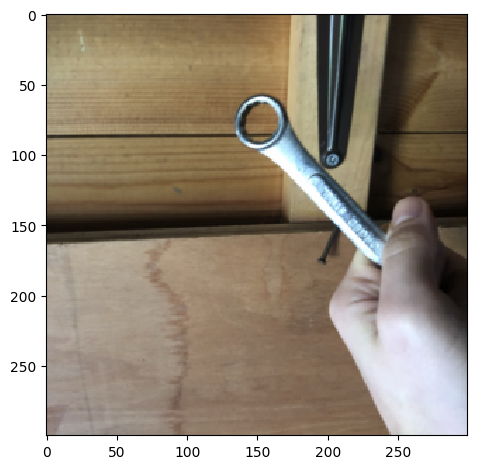

In [ ]:
from matplotlib import pyplot as plt
from skimage import io
print(testlabels[0])
down_scaled_image = resize(testimages[3], (300, 300))
io.imshow(down_scaled_image)
plt.show()

In [ ]:
model.save("model2.keras")